In [2]:
import sys
print(sys.executable)
!conda info | grep 'active env'

/home/masse/mambaforge/envs/scvi/bin/python
     active environment : scvi
    active env location : /home/masse/mambaforge/envs/scvi


In [3]:
import os
import copy
import scvi
import anndata as ad
import pegasus as pg
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sparse

/home/masse/mambaforge/envs/scvi/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/masse/mambaforge/envs/scvi/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 0
/home/masse/mambaforge/envs/scvi/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/masse/mambaforge/envs/scvi/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword 

# Mouse Living Brain - scVI Annotation
Nicolas Masse, Donghoon Lee  
August 2023

### Load the filtered Living Brain dataset and the Allen Brian Map dataset. For the later, only visual and retrosplenal cortices are included.

In [4]:
# allen_path = "llen_brain_map_vis_rsp_v2.h5ad"
allen_path = "./data/allen_brain_map_vis_rsp_v2.h5ad"
# living_brain_path = "/sc/arion/work/massen06/living_brain1/anndata/mouse_living_brain_pre_final_clean.h5ad"
living_brain_path = "./data/mouse_living_brain_pre_final_clean_var_genes.h5ad"

In [5]:
adata_allen = sc.read_h5ad(allen_path, "r")
adata_lb = sc.read_h5ad(living_brain_path)
adata_lb.X = adata_lb.layers["counts"]

In [6]:
# Ensure region labels are visual, retrosplenal corex
adata_allen.obs.region_label.unique()

['RSP', 'VIS', 'VISl', 'VISm', 'VISp']
Categories (5, object): ['RSP', 'VIS', 'VISl', 'VISm', 'VISp']

### Select only highly variable genes (computed in qc.ipynb)

In [7]:
adata_lb = adata_lb[:, adata_lb.var.highly_variable_features]
var_genes_lb = np.array([v.lower() for v in adata_lb.var.gene_name.values])

In [8]:
idx_allen = []
idx_lb = []

genes_allen = adata_allen.var.gene_name.values
genes_allen = np.array([g.lower() for g in genes_allen])
for n, g in enumerate(var_genes_lb):
    if g.lower() in genes_allen:
        idx = np.where(genes_allen == g)[0]
        if len(idx) > 0:
            idx_allen.append(idx[0])
            idx_lb.append(n)
            
print(f"Length of idx_allen: {len(idx_allen)} and idx_lb: {len(idx_lb)}")

Length of idx_allen: 1704 and idx_lb: 1704


In [9]:
adata_lb = adata_lb[:, idx_lb]
adata_allen = adata_allen[:, idx_allen]

adata_allen = adata_allen.to_memory()

### As a sanity check, ensure mean expression is sinilar between the two datasets

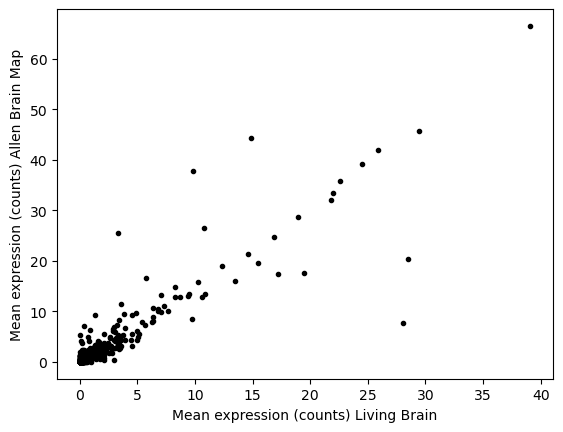

In [10]:
mean_gene_exp_lb = np.mean(adata_lb.X, axis=0)
mean_gene_exp_allen = np.mean(adata_allen.X, axis=0)
plt.plot(mean_gene_exp_lb, mean_gene_exp_allen, 'k.')
plt.xlabel('Mean expression (counts) Living Brain')
plt.ylabel('Mean expression (counts) Allen Brain Map')
plt.show()

### Check the cell contributions in the Allen Brian Map  
It's neuron heavy...

In [11]:
x = np.array(adata_allen.obs['class_label'])
u,c = np.unique(x, return_counts=True)
idx = np.argsort(c)
for i in idx[::-1]:
    print(u[i], c[i])

Glutamatergic 294884
GABAergic 49234
Non-Neuronal 2865


### Add class annotation to the living brain data that is similar to the Allen Data

In [12]:
lb_class = []
for n in adata_lb.obs["anno"]:
    if "Glut" in n:
        lb_class.append("Glutamatergic")
    elif "GABA" in n:
        lb_class.append("GABAergic")
    else:
        lb_class.append("Non-Neuronal")
        
adata_lb.obs["class_label"] = lb_class

/tmp/ipykernel_97061/1859922298.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_lb.obs["class_label"] = lb_class


### Combine datasets

In [13]:
adata_lb.obs["Brain_bank"] = "LB"
adata_allen.obs["Brain_bank"] = "Allen"

In [14]:
X = sparse.vstack([adata_allen.X, adata_lb.X]).astype(np.int32)

In [15]:
class_id = list(adata_allen.obs["class_label"].values) + lb_class
subclass_id = list(adata_allen.obs["subclass_label"].values) + list(adata_lb.obs["anno"].values) 
bb = list(adata_allen.obs.Brain_bank.values) + list(adata_lb.obs.Brain_bank.values) 
print(len(class_id), len(subclass_id), len(bb), X.shape)

407033 407033 407033 (407033, 1704)


In [16]:
adata = ad.AnnData(X)

In [17]:
adata.obs["class_id"] = class_id
adata.obs["subclass_id"] = subclass_id
adata.obs["Brain_bank"] = bb

In [18]:
adata.var_names = adata_lb.var.gene_name
adata.var["gene_name"] = adata_lb.var.gene_name

In [19]:
del adata_lb, adata_allen

### Train scVI VAE

In [20]:
adata_ref = adata.copy()
scvi.model.SCVI.setup_anndata(adata_ref, batch_key="Brain_bank")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [21]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=1,
    n_latent=10,
    n_hidden=256,
    dispersion="gene-batch",
)

vae_ref = scvi.model.SCVI(adata_ref, **arches_params)
vae_ref.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:37<00:00, 16.88s/it, loss=649, v_num=1]


In [22]:
vae_ref.history.keys()

dict_keys(['train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

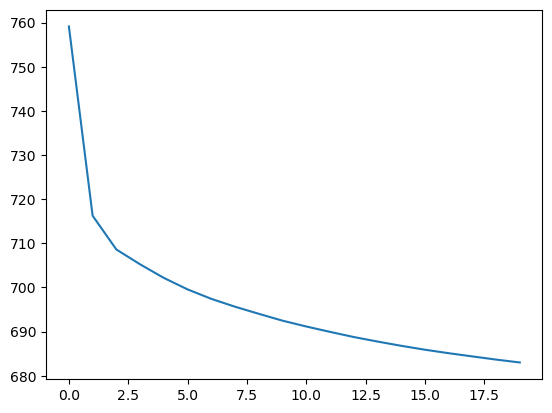

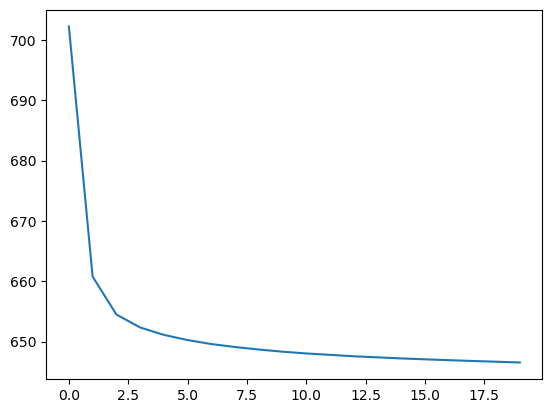

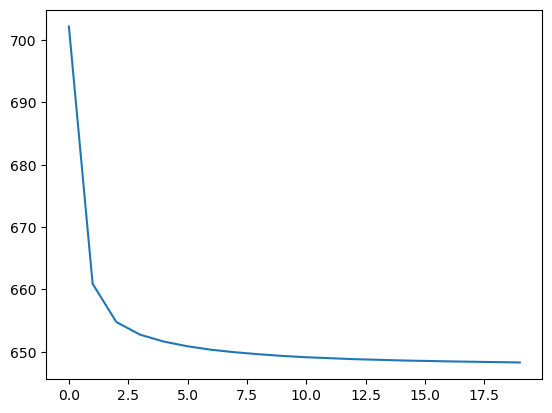

In [23]:
plt.plot(vae_ref.history["elbo_train"])
plt.show()
plt.plot(vae_ref.history["reconstruction_loss_train"])
plt.show()
plt.plot(vae_ref.history["train_loss_epoch"])
plt.show()

### Visualize data

In [24]:
adata_ref.obsm["X_scVI"] = vae_ref.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_scVI")
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

/home/masse/mambaforge/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/masse/mambaforge/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


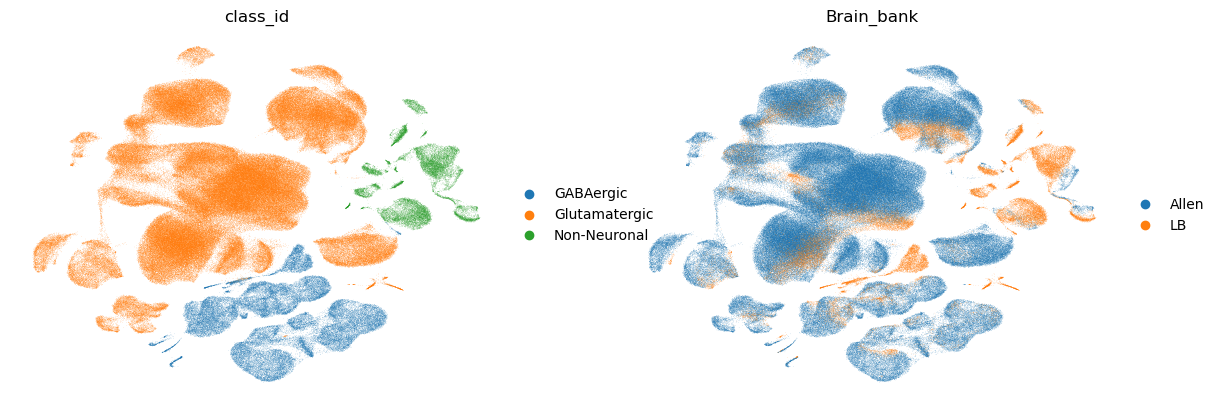

In [25]:
sc.pl.umap(
    adata_ref,
    color=["class_id", "Brain_bank"],
    frameon=False,
    ncols=2,
)

/home/masse/mambaforge/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/masse/mambaforge/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/masse/mambaforge/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


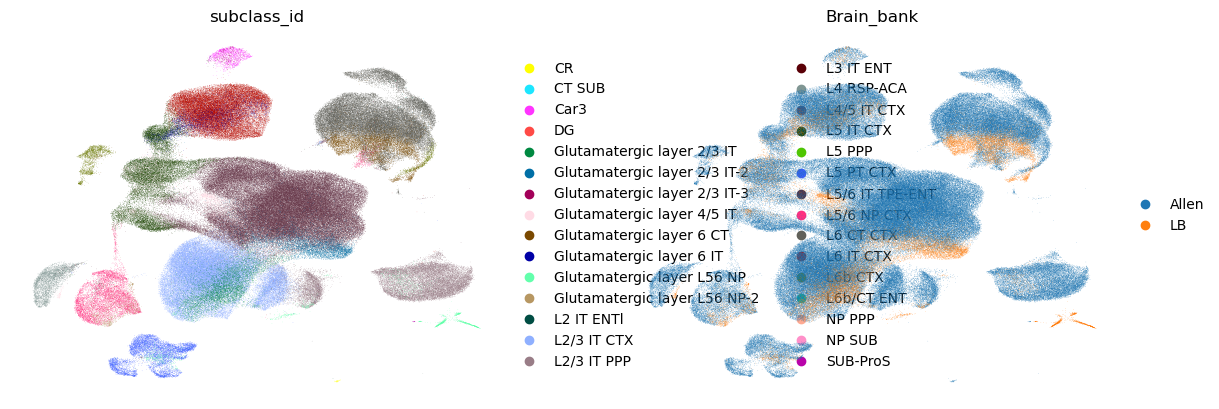

In [26]:
idx = ["Glut" in n  for n in adata_ref.obs.class_id.values]
adata0 = adata_ref[idx]
sc.pl.umap(
    adata0,
    color=["subclass_id", "Brain_bank"],
    frameon=False,
    ncols=2,
)

/home/masse/mambaforge/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/masse/mambaforge/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/masse/mambaforge/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


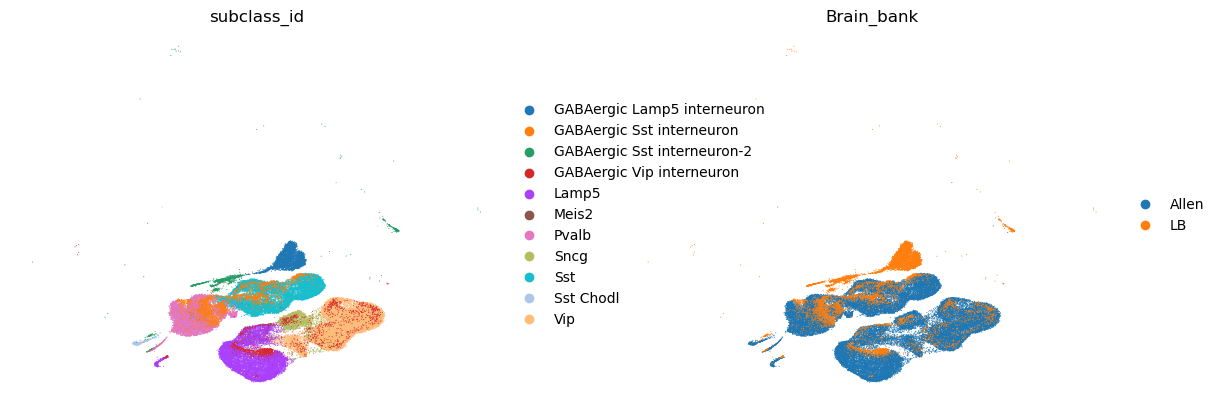

In [27]:
idx = ["GABA" in n  for n in adata_ref.obs.class_id.values]
adata0 = adata_ref[idx]
sc.pl.umap(
    adata0,
    color=["subclass_id", "Brain_bank"],
    frameon=False,
    ncols=2,
)

### Train scVI cell annotation classifier
Only include Allen cell classes with at least 200 cells

In [28]:
adata.obs["celltype_scanvi"] = "Unknown"
mask = adata.obs["Brain_bank"] == "Allen"
adata.obs["celltype_scanvi"][mask] = adata.obs.subclass_id[mask].values

In [29]:
labels, counts = np.unique(adata.obs["celltype_scanvi"], return_counts=True)

In [30]:
print(labels)
print(counts)

['Astro' 'CR' 'CT SUB' 'Car3' 'DG' 'Endo' 'L2 IT ENTl' 'L2/3 IT CTX'
 'L2/3 IT PPP' 'L3 IT ENT' 'L4 RSP-ACA' 'L4/5 IT CTX' 'L5 IT CTX' 'L5 PPP'
 'L5 PT CTX' 'L5/6 IT TPE-ENT' 'L5/6 NP CTX' 'L6 CT CTX' 'L6 IT CTX'
 'L6b CTX' 'L6b/CT ENT' 'Lamp5' 'Meis2' 'Micro-PVM' 'NP PPP' 'NP SUB'
 'Oligo' 'Pvalb' 'SMC-Peri' 'SUB-ProS' 'Sncg' 'Sst' 'Sst Chodl' 'Unknown'
 'VLMC' 'Vip']
[   675     38     15   1739      1    235      1  52414  20903      1
   4091 104934  19837      1   7686     71   8704  41327  30309   2738
     20  11340      5    177     10     29   1707   9239     49     15
   2528  12404    319  60050     22  13399]


In [31]:
idx_good = np.where(counts >= 200)[0]
good_labels = [labels[i] for i in idx_good]

In [32]:
adata_filtered = adata[adata.obs.celltype_scanvi.isin(good_labels)]

In [33]:
np.unique(adata_filtered.obs["celltype_scanvi"], return_counts=True)

(array(['Astro', 'Car3', 'Endo', 'L2/3 IT CTX', 'L2/3 IT PPP',
        'L4 RSP-ACA', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PT CTX',
        'L5/6 NP CTX', 'L6 CT CTX', 'L6 IT CTX', 'L6b CTX', 'Lamp5',
        'Oligo', 'Pvalb', 'Sncg', 'Sst', 'Sst Chodl', 'Unknown', 'Vip'],
       dtype=object),
 array([   675,   1739,    235,  52414,  20903,   4091, 104934,  19837,
          7686,   8704,  41327,  30309,   2738,  11340,   1707,   9239,
          2528,  12404,    319,  60050,  13399]))

In [34]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae_ref,
    adata=adata_filtered,
    unlabeled_category="Unknown",
    labels_key="celltype_scanvi",
)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [39]:
lvae.train(max_epochs=20, n_samples_per_label=200)

INFO     Training for 20 epochs.                                                                                   


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [11:47<00:00, 35.37s/it, loss=747, v_num=1]


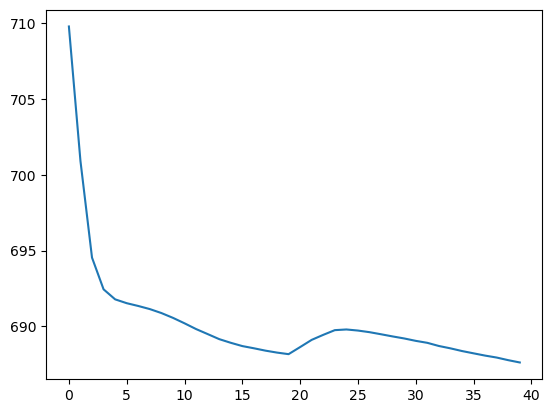

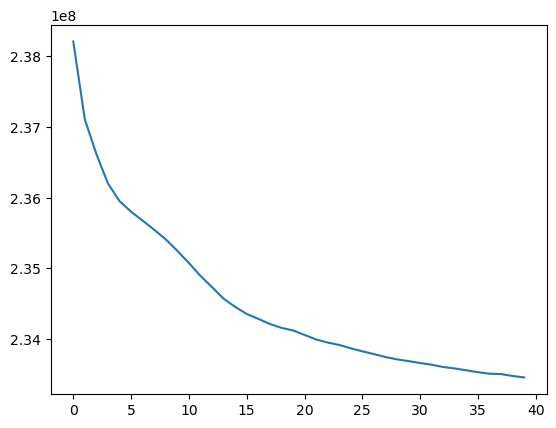

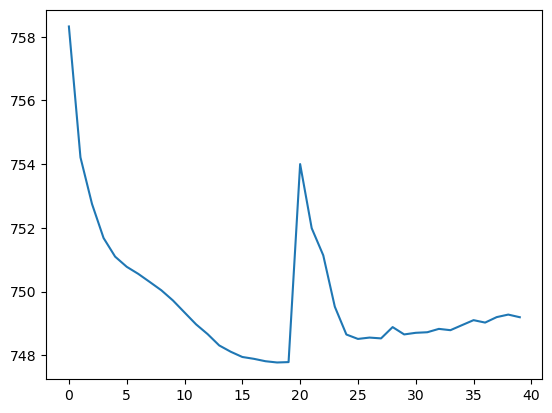

In [45]:
plt.plot(lvae.history["elbo_train"])
plt.show()
plt.plot(lvae.history["reconstruction_loss_train"])
plt.show()
plt.plot(lvae.history["train_loss_epoch"])
plt.show()

In [46]:
adata_filtered.obs["C_scANVI"] = lvae.predict(adata_filtered)
adata_filtered.obsm["X_scANVI"] = lvae.get_latent_representation(adata_filtered)

In [42]:
#from scvi.model.utils import mde
#adata_filtered.obsm["X_mde_scanvi"] = mde(adata_filtered.obsm["X_scANVI"])

In [43]:
"""
# in order to make colors matchup
adata.obs.C_scANVI = pd.Categorical(
    adata.obs.C_scANVI.values, categories=adata.obs.cell_ontology_class.cat.categories
)
sc.pl.embedding(
    adata,
    basis="X_mde_scanvi",
    color=["cell_ontology_class", "C_scANVI"],
    ncols=1,
    frameon=False,
    palette=adata.uns["cell_ontology_class_colors"],
)
"""

'\n# in order to make colors matchup\nadata.obs.C_scANVI = pd.Categorical(\n    adata.obs.C_scANVI.values, categories=adata.obs.cell_ontology_class.cat.categories\n)\nsc.pl.embedding(\n    adata,\n    basis="X_mde_scanvi",\n    color=["cell_ontology_class", "C_scANVI"],\n    ncols=1,\n    frameon=False,\n    palette=adata.uns["cell_ontology_class_colors"],\n)\n'

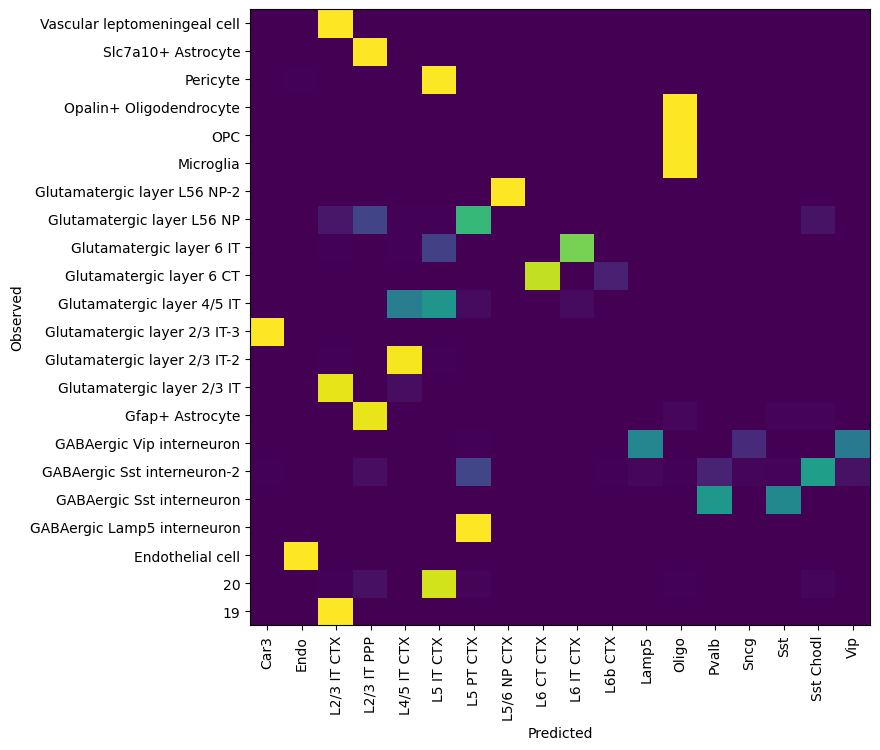

In [44]:
a = adata_filtered[adata_filtered.obs.Brain_bank == "LB"]
df = a.obs.groupby(["subclass_id", "C_scANVI"]).size().unstack(fill_value=0)
conf_mat = df / df.sum(axis=1).values[:, np.newaxis]
plt.figure(figsize=(8, 8))
_ = plt.pcolor(conf_mat)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.show()